In [1]:
import os
import glob
import keras
import tensorflow as tf
import numpy as np
from binary_train_and_eval import gen_dataset

2024-12-12 10:26:18.252371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:26:18.278863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 10:26:18.291578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:26:18.317630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 10:26:28.266666: W tensorflow/compiler/tf2

In [2]:
keras.config.enable_unsafe_deserialization()

In [3]:
MODEL_DIR = "out"
model_files = [file for file in glob.glob(os.path.join(MODEL_DIR, "best*_rgb.keras"))]
#model_files = [max(glob.glob(os.path.join("checkpoints", model_dir, "*")), key=os.path.getctime) for model_dir in os.listdir("checkpoints") if model_dir.endswith("_rgb")]
print(model_files)
TEST_DATA_PATH = os.path.join("_data", "combined_masked", "test")
INPUT_SHAPE = (224, 224, 3)

['out/bestInceptionV3_rgb.keras', 'out/bestVisionTransformer_rgb.keras', 'out/bestAlexNet_rgb.keras', 'out/bestResNet152V2_rgb.keras', 'out/bestMobileNetV3Large_rgb.keras', 'out/bestVGG19_rgb.keras', 'out/bestConvNeXtLarge_rgb.keras']


In [4]:
models = {file.split("/")[-1].replace('best', '').replace('_rgb.keras', ''): keras.saving.load_model(file, custom_objects={'lr': None}) for file in model_files}

2024-12-12 10:26:53.198671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [5]:
print(models.keys())

dict_keys(['InceptionV3', 'VisionTransformer', 'AlexNet', 'ResNet152V2', 'MobileNetV3Large', 'VGG19', 'ConvNeXtLarge'])


In [6]:
test_dataset = gen_dataset(TEST_DATA_PATH, batch_size=8, lab=False, input_shape=INPUT_SHAPE, aug=False, deterministic=True)

Found 8568 files belonging to 2 classes.


In [7]:
test_dataset = keras.utils.image_dataset_from_directory(TEST_DATA_PATH, 
                                                        batch_size=8, 
                                                        image_size=INPUT_SHAPE[:2], 
                                                        crop_to_aspect_ratio=True, 
                                                        labels="inferred", 
                                                        label_mode="binary",
                                                        shuffle=False)
test_dataset = test_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=2)))

Found 8568 files belonging to 2 classes.


In [8]:
y_trues = tf.concat(list(test_dataset.map(lambda x,y: y)), axis=0)

2024-12-12 10:29:12.910751: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def reduce_y(y):
    return np.argmax(y, axis=1)

In [10]:
total = len(y_trues)
unique, counts = np.unique(reduce_y(y_trues), return_counts=True)
label_weights = 1 - (counts / total)

In [11]:
label_weights

array([0.31862745, 0.68137255])

In [12]:
preds = dict()
results = dict()

In [13]:
metrics=[
    keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(label_weights=label_weights),
    tf.keras.metrics.F1Score(),
]

In [14]:
for name, model in models.items():
    print(f"Evaluating {name}")
    result = {}
    
    y_preds = tf.nn.softmax(model.predict(test_dataset.map(lambda x,y: x)))
    
    for metric in metrics:
        result[metric.name] = metric(y_trues, y_preds).numpy()
        
    print(result)
    
    results[name] = result
    preds[name] = {
        'y_true': y_trues,
        'y_pred': y_preds
    }

Evaluating InceptionV3


I0000 00:00:1733995757.148163  936224 service.cc:146] XLA service 0x14a194003890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733995757.148210  936224 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-12 10:29:17.300573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-12 10:29:18.791488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   7/1071 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step 

I0000 00:00:1733995768.620232  936224 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1071/1071 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step
{'binary_accuracy': 0.8531746, 'recall': 0.8531746, 'auc': 0.9208971, 'f1_score': array([0.90136415, 0.7129164 ], dtype=float32)}
Evaluating VisionTransformer


2024-12-12 10:29:56.675198: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 200 bytes spill stores, 200 bytes spill loads

2024-12-12 10:30:06.218030: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 204 bytes spill stores, 204 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step
{'binary_accuracy': 0.7670985, 'recall': 0.7670985, 'auc': 0.87183034, 'f1_score': array([0.85301805, 0.43938753], dtype=float32)}
Evaluating AlexNet


2024-12-12 10:31:14.662678: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_210', 88 bytes spill stores, 88 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step
{'binary_accuracy': 0.7690632, 'recall': 0.7690632, 'auc': 0.8587642, 'f1_score': array([0.83932424, 0.58960176], dtype=float32)}
Evaluating ResNet152V2
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step
{'binary_accuracy': 0.789916, 'recall': 0.789916, 'auc': 0.8747337, 'f1_score': array([0.8550607, 0.6184014], dtype=float32)}
Evaluating MobileNetV3Large
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step
{'binary_accuracy': 0.7683707, 'recall': 0.7683707, 'auc': 0.8212725, 'f1_score': array([0.8451152, 0.5408781], dtype=float32)}
Evaluating VGG19


2024-12-12 10:33:35.012986: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step
{'binary_accuracy': 0.75387096, 'recall': 0.75387096, 'auc': 0.80656964, 'f1_score': array([0.8387598 , 0.48022014], dtype=float32)}
Evaluating ConvNeXtLarge


2024-12-12 10:34:40.714630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2024-12-12 10:35:08.484896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 52 bytes spill stores, 52 bytes spill loads

2024-12-12 10:35:55.363434: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 156 bytes spill stores, 156 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 181s 47ms/step
{'binary_accuracy': 0.74351406, 'recall': 0.74351406, 'auc': 0.7898, 'f1_score': array([0.83437586, 0.43179548], dtype=float32)}


In [16]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in preds.items():
    y_true = np.argmax(data['y_true'], axis=1)
    
    y_pred = np.argmax(data['y_pred'], axis=1)
    total = len(y_true)
    unique, counts = np.unique(y_true, return_counts=True)
    label_weights = 1 - (counts / total)
    
    sample_weight = np.array([label_weights[label] for label in y_true])
    report = classification_report(y_true, y_pred, sample_weight=sample_weight, output_dict=True)['weighted avg']
    del report['support']
    report['accuracy'] = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weight)
    report['auc'] = roc_auc_score(y_true, y_pred)
    
    report_df.loc[name] = list(report.values())

/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [17]:
report_df

,precision,recall,f1-score,accuracy,auc
InceptionV3,0.835426,0.778372,0.768530,0.778372,0.778372
VisionTransformer,0.480499,0.499938,0.333956,0.499938,0.499938
AlexNet,0.867424,0.830494,0.826125,0.830494,0.830494
ResNet152V2,0.833989,0.778639,0.769071,0.778639,0.778639
MobileNetV3Large,0.677753,0.501672,0.337640,0.501672,0.501672
VGG19,0.250000,0.500000,0.333333,0.500000,0.500000
ConvNeXtLarge,0.250000,0.500000,0.333333,0.500000,0.500000


In [35]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & precision & recall & f1-score & accuracy & auc \\\\\n\\midrule\nInceptionV3 & 0.8354 & 0.7784 & 0.7685 & 0.7784 & 0.7784 \\\\\nVisionTransformer & 0.4805 & 0.4999 & 0.3340 & 0.4999 & 0.4999 \\\\\nAlexNet & 0.8674 & 0.8305 & 0.8261 & 0.8305 & 0.8305 \\\\\nResNet152V2 & 0.8340 & 0.7786 & 0.7691 & 0.7786 & 0.7786 \\\\\nMobileNetV3Large & 0.6778 & 0.5017 & 0.3376 & 0.5017 & 0.5017 \\\\\nVGG19 & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\nConvNeXtLarge & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [36]:
results

{'InceptionV3': {'binary_accuracy': 0.8531746,
  'recall': 0.8531746,
  'auc': 0.92215353,
  'f1_score': array([0.90136415, 0.7129164 ], dtype=float32)},
 'VisionTransformer': {'binary_accuracy': 0.7670985,
  'recall': 0.7670985,
  'auc': 0.8719631,
  'f1_score': array([0.85301805, 0.43938753], dtype=float32)},
 'AlexNet': {'binary_accuracy': 0.7690632,
  'recall': 0.7690632,
  'auc': 0.85924745,
  'f1_score': array([0.83932424, 0.58960176], dtype=float32)},
 'ResNet152V2': {'binary_accuracy': 0.789916,
  'recall': 0.789916,
  'auc': 0.87547547,
  'f1_score': array([0.8550607, 0.6184014], dtype=float32)},
 'MobileNetV3Large': {'binary_accuracy': 0.7683707,
  'recall': 0.7683707,
  'auc': 0.82163244,
  'f1_score': array([0.8451152, 0.5408781], dtype=float32)},
 'VGG19': {'binary_accuracy': 0.75387096,
  'recall': 0.75387096,
  'auc': 0.80686206,
  'f1_score': array([0.8387598 , 0.48022014], dtype=float32)},
 'ConvNeXtLarge': {'binary_accuracy': 0.74351406,
  'recall': 0.74351406,
  'auc

In [25]:
#results = {name: {key: value.numpy() for key, value in data.items() } for name, data in results.items()}

In [26]:
import pickle
with open(os.path.join("out", "result.pkl"), "wb+") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
results_data = [{**{'name': name}, **data, 'f1_score': data['f1_score'][0]} for name, data in results.items()]

In [28]:
import pandas as pd
df = pd.DataFrame(results_data)

In [29]:
df

,name,binary_accuracy,recall,auc,f1_score
0,InceptionV3,0.853175,0.853175,0.922154,0.901364
1,VisionTransformer,0.767098,0.767098,0.871963,0.853018
2,AlexNet,0.769063,0.769063,0.859247,0.839324
3,ResNet152V2,0.789916,0.789916,0.875475,0.855061
4,MobileNetV3Large,0.768371,0.768371,0.821632,0.845115
5,VGG19,0.753871,0.753871,0.806862,0.838760
6,ConvNeXtLarge,0.743514,0.743514,0.790111,0.834376


In [30]:
df.set_index('name')
df.loc["Sum"] = df.sum(numeric_only=True)

df.to_latex(float_format="%.4f")

'\\begin{tabular}{llrrrr}\n\\toprule\n & name & binary_accuracy & recall & auc & f1_score \\\\\n\\midrule\n0 & InceptionV3 & 0.8532 & 0.8532 & 0.9222 & 0.9014 \\\\\n1 & VisionTransformer & 0.7671 & 0.7671 & 0.8720 & 0.8530 \\\\\n2 & AlexNet & 0.7691 & 0.7691 & 0.8592 & 0.8393 \\\\\n3 & ResNet152V2 & 0.7899 & 0.7899 & 0.8755 & 0.8551 \\\\\n4 & MobileNetV3Large & 0.7684 & 0.7684 & 0.8216 & 0.8451 \\\\\n5 & VGG19 & 0.7539 & 0.7539 & 0.8069 & 0.8388 \\\\\n6 & ConvNeXtLarge & 0.7435 & 0.7435 & 0.7901 & 0.8344 \\\\\nSum & NaN & 5.4450 & 5.4450 & 5.9474 & 5.9670 \\\\\n\\bottomrule\n\\end{tabular}\n'

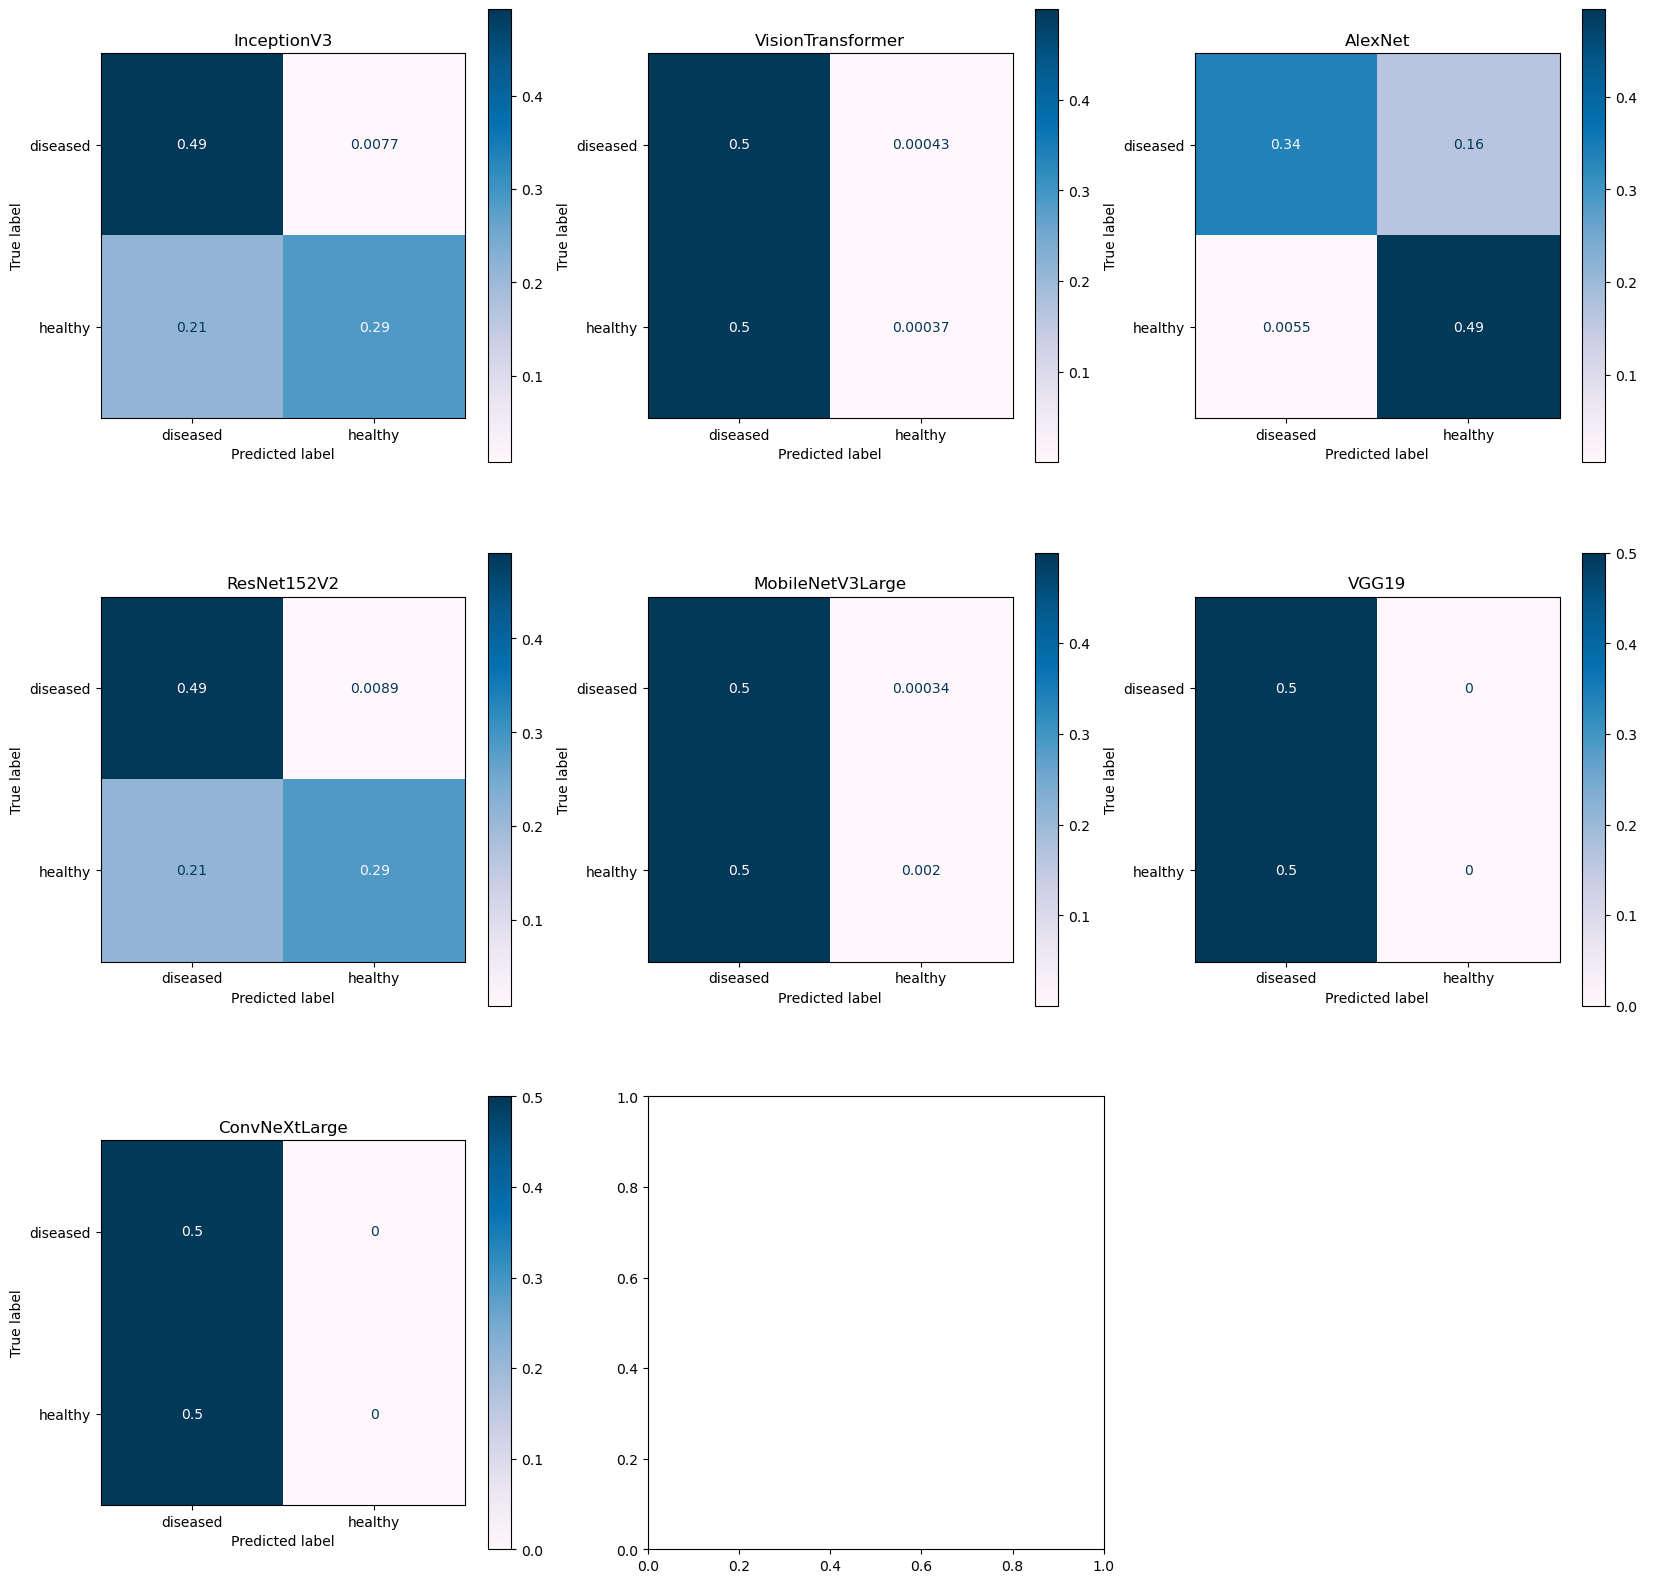

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, preds.items()):
    y_true = np.argmax(data['y_true'], axis=1)
    
    y_pred = np.argmax(data['y_pred'], axis=1)
    total = len(y_true)
    unique, counts = np.unique(y_true, return_counts=True)
    label_weights = 1 - (counts / total)
    
    sample_weight = np.array([label_weights[label] for label in y_true])
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   normalize='all', 
                                                   display_labels=["diseased", 'healthy'],
                                                   sample_weight=sample_weight)
    disp.ax_.set_title(name)
plt.show()

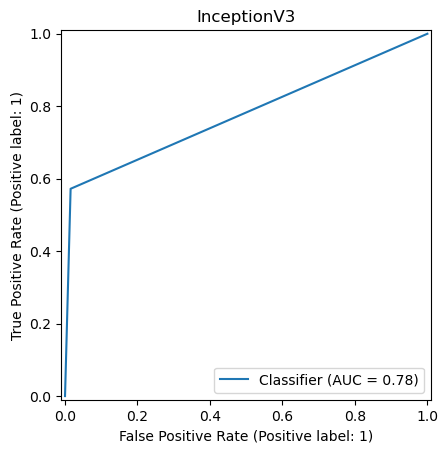

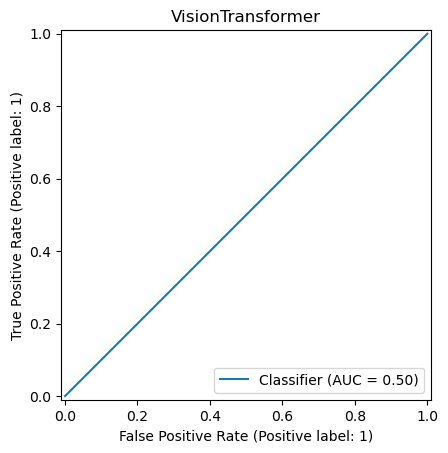

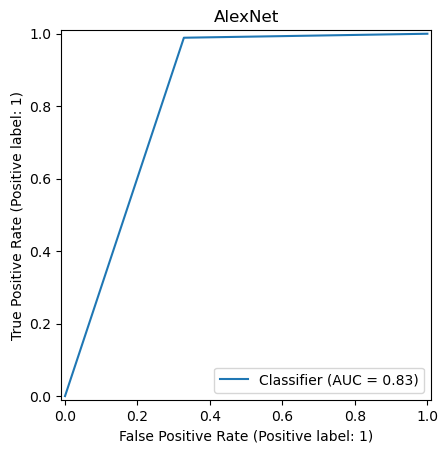

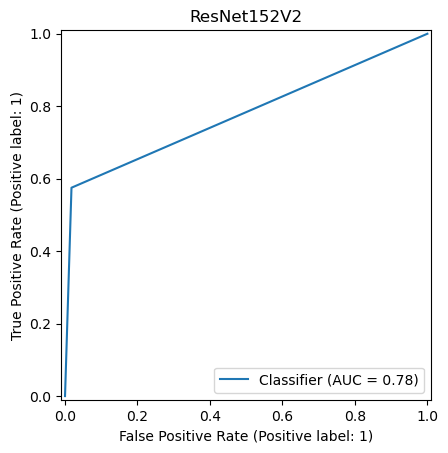

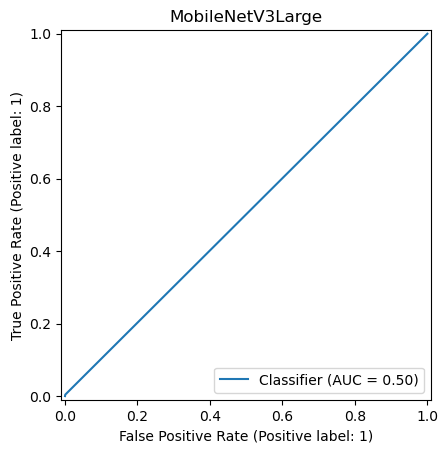

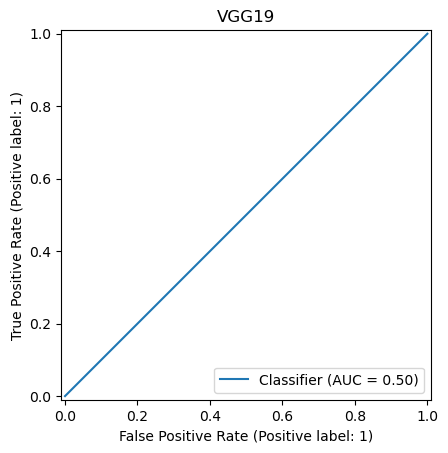

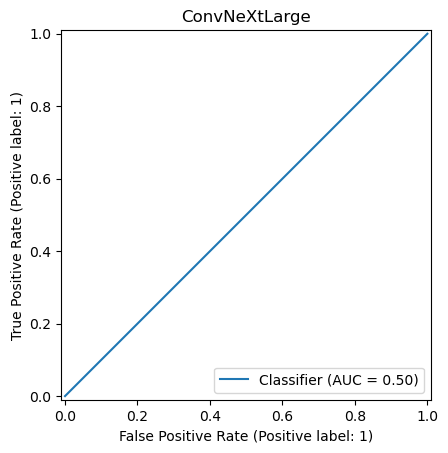

In [19]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = RocCurveDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()

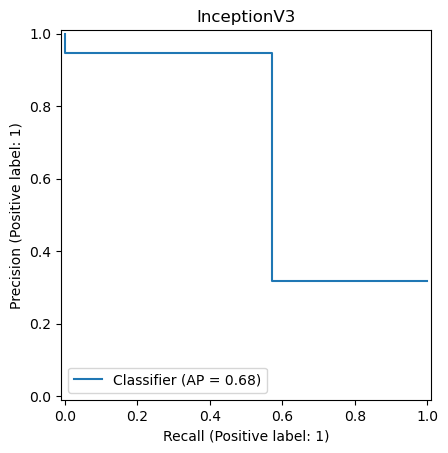

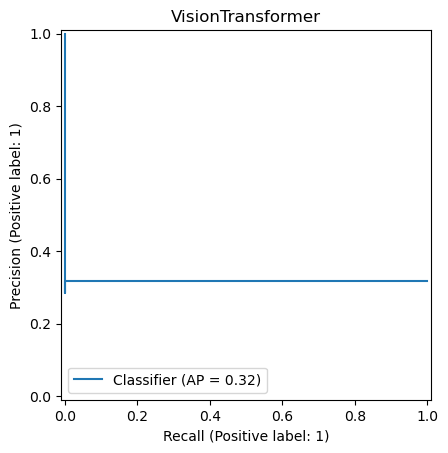

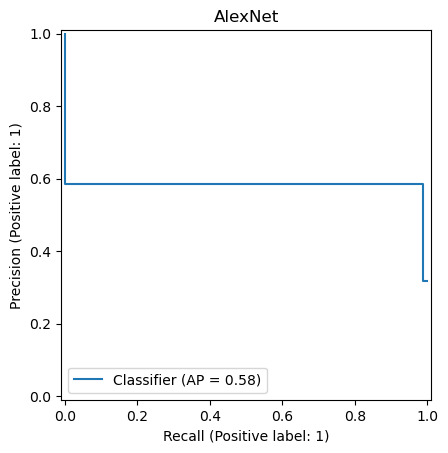

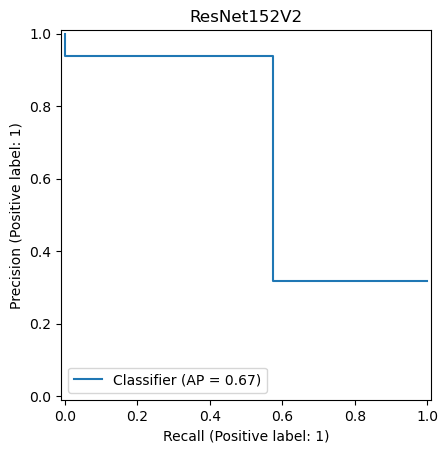

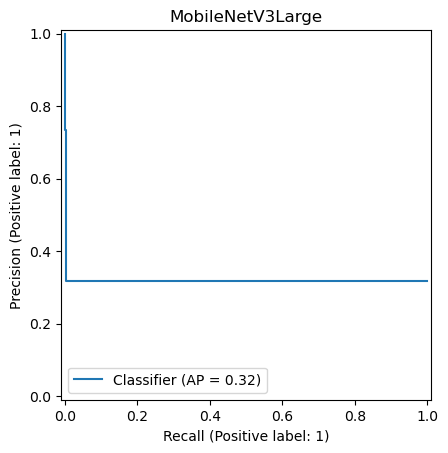

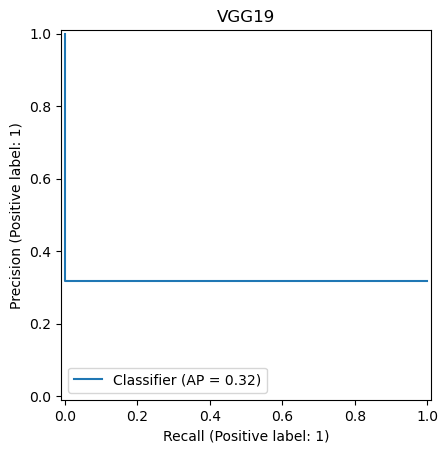

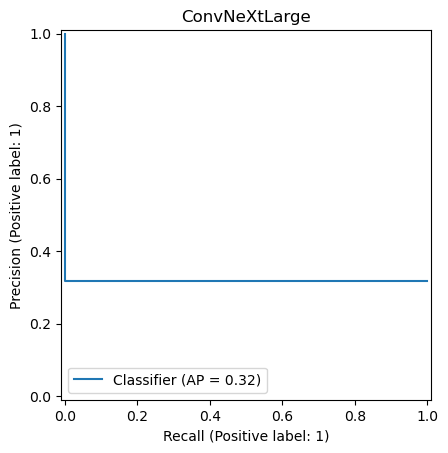

In [20]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = PrecisionRecallDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()